# ART - Adversarial Training Defence for YOLOv8 (Tank Dataset)

이 노트북은 적대적 훈련(Adversarial Training)을 통해 YOLOv8 객체 탐지 모델을 강건하게 만드는 방어 기법을 시연합니다.

**방어 기법**: Adversarial Training (Madry's PGD-based)  
**모델**: YOLOv8n  
**데이터셋**: Custom Tank Detection Dataset

## 적대적 훈련이란?

적대적 훈련은 모델을 학습할 때 정상 데이터뿐만 아니라 적대적 예제도 함께 학습시켜 모델의 강건성을 향상시키는 방법입니다.

**핵심 아이디어**: "적을 알고 나를 알면 백전불태"
- 공격을 방어하는 가장 좋은 방법은 공격 자체를 학습에 포함시키는 것입니다.

## 1. 환경 설정 및 임포트

In [11]:
import os
import sys
import numpy as np
import torch
import cv2
import yaml
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

# Ultralytics YOLO
from ultralytics import YOLO

# ART imports
from art.estimators.object_detection import PyTorchYolo
from art.attacks.evasion import ProjectedGradientDescent

# Matplotlib 설정
plt.style.use('ggplot')
%matplotlib inline

# CUDA 정보
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5080
Using device: cuda


## 2. 데이터셋 설정

In [12]:
# 경로 설정 - 노트북이 실행되는 위치 기준 상대 경로
import os
from pathlib import Path

# Get the directory where this notebook is located
NOTEBOOK_DIR = Path(os.getcwd())

# All paths relative to notebook directory
# Assuming notebook is in: art_training/defences/
# Project root is: ../../ from notebook
PROJECT_ROOT = NOTEBOOK_DIR / ".." / ".."

# Dataset and model paths relative to project root
DATA_YAML = PROJECT_ROOT / "dataset_only_tank" / "data.yaml"
DATASET_PATH = PROJECT_ROOT / "dataset_only_tank"
ORIGINAL_MODEL_PATH = PROJECT_ROOT / "runs" / "detect" / "train_only_tank" / "weights" / "best.pt"

# 적대적 훈련을 위한 새로운 데이터셋 및 모델 저장 경로 (노트북과 같은 폴더)
ADV_DATASET_PATH = NOTEBOOK_DIR / "adv_dataset"
ADV_DATA_YAML = NOTEBOOK_DIR / "adv_dataset" / "data.yaml"
DEFENDED_MODEL_SAVE_PATH = NOTEBOOK_DIR / "adversarially_trained_model.pt"

# Resolve to absolute paths for verification
DATA_YAML = DATA_YAML.resolve()
DATASET_PATH = DATASET_PATH.resolve()
ORIGINAL_MODEL_PATH = ORIGINAL_MODEL_PATH.resolve()

print(f"Notebook directory: {NOTEBOOK_DIR.resolve()}")
print(f"Project root: {PROJECT_ROOT.resolve()}")
print(f"Data YAML: {DATA_YAML}")
print(f"Original model: {ORIGINAL_MODEL_PATH}")

# data.yaml 로드
with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)

print("\nDataset configuration:")
print(f"  Number of classes: {data_config['nc']}")
print(f"  Class names: {data_config['names']}")
print(f"\nOriginal dataset paths:")
print(f"  Training images: {DATASET_PATH}/train/images")
print(f"  Validation images: {DATASET_PATH}/valid/images")
print(f"  Test images: {DATASET_PATH}/test/images")
print(f"\nAdversarial dataset will be created at:")
print(f"  {ADV_DATASET_PATH.resolve()}")

# 클래스 이름
CLASS_NAMES = data_config['names']

Notebook directory: /home/jaehyun/art_train/yolo_train/art_training/defences
Project root: /home/jaehyun/art_train/yolo_train
Data YAML: /home/jaehyun/art_train/yolo_train/dataset_only_tank/data.yaml
Original model: /home/jaehyun/art_train/yolo_train/runs/detect/train_only_tank/weights/best.pt

Dataset configuration:
  Number of classes: 1
  Class names: {0: 'Tank'}

Original dataset paths:
  Training images: /home/jaehyun/art_train/yolo_train/dataset_only_tank/train/images
  Validation images: /home/jaehyun/art_train/yolo_train/dataset_only_tank/valid/images
  Test images: /home/jaehyun/art_train/yolo_train/dataset_only_tank/test/images

Adversarial dataset will be created at:
  /home/jaehyun/art_train/yolo_train/art_training/defences/adv_dataset


## 3. 유틸리티 함수

In [13]:
def load_images_from_directory(image_dir, num_images=None, img_size=640):
    """디렉토리에서 이미지 로드"""
    image_dir = Path(image_dir).resolve()
    
    # 이미지 파일 검색
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG', '*.png', '*.PNG']:
        image_files.extend(list(image_dir.glob(ext)))
    
    if len(image_files) == 0:
        print(f"Warning: No images found in {image_dir}")
        return np.array([]), []
    
    image_files = sorted(image_files)
    if num_images is not None:
        image_files = image_files[:num_images]
    
    images = []
    for img_path in tqdm(image_files, desc="Loading images"):
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_size, img_size), Image.BICUBIC)
        img_array = np.array(img)
        img_array = img_array.transpose(2, 0, 1)  # (C, H, W)
        images.append(img_array)
    
    # [0, 255] 범위로 유지
    return np.array(images, dtype=np.float32), [str(p) for p in image_files]


def extract_predictions(predictions, conf_thresh=0.5):
    """예측 결과에서 신뢰도 임계값 이상의 탐지만 추출"""
    if not isinstance(predictions, dict):
        return [], [], []
    
    predictions_score = list(predictions["scores"])
    predictions_t = [i for i, x in enumerate(predictions_score) if x > conf_thresh]
    
    if len(predictions_t) == 0:
        return [], [], []
    
    predictions_boxes = [[(predictions["boxes"][i][0], predictions["boxes"][i][1]), 
                          (predictions["boxes"][i][2], predictions["boxes"][i][3])] 
                         for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    
    predictions_class = []
    for i in predictions_t:
        label_idx = int(predictions["labels"][i])
        if 0 <= label_idx < len(CLASS_NAMES):
            predictions_class.append(CLASS_NAMES[label_idx])
        else:
            predictions_class.append(CLASS_NAMES[0])
    
    return predictions_class, predictions_boxes, predictions_scores


def filter_boxes(predictions, conf_thresh=0.5):
    """신뢰도 임계값으로 예측 필터링"""
    dictionary = {}
    boxes_list = []
    scores_list = []
    labels_list = []
    
    for i in range(len(predictions["boxes"])):
        score = predictions["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions["boxes"][i])
            scores_list.append(predictions["scores"][i])
            labels_list.append(predictions["labels"][i])
    
    if len(boxes_list) == 0:
        dictionary["boxes"] = np.array([], dtype=np.float32).reshape(0, 4)
        dictionary["scores"] = np.array([], dtype=np.float32)
        dictionary["labels"] = np.array([], dtype=np.int64)
    else:
        dictionary["boxes"] = np.vstack(boxes_list)
        dictionary["scores"] = np.hstack(scores_list)
        dictionary["labels"] = np.hstack(labels_list)
    
    return dictionary


def calculate_detection_metrics(predictions, conf_thresh=0.5):
    """탐지 성능 메트릭 계산"""
    total_detections = 0
    confidences = []
    
    for pred in predictions:
        valid_scores = [s for s in pred['scores'] if s > conf_thresh]
        total_detections += len(valid_scores)
        confidences.extend(valid_scores)
    
    avg_confidence = np.mean(confidences) if len(confidences) > 0 else 0.0
    
    return {
        'total_detections': total_detections,
        'avg_confidence': avg_confidence,
        'num_images': len(predictions)
    }


def plot_image_with_boxes(img, boxes, pred_cls, pred_scores=None, title="Detection"):
    """이미지에 바운딩 박스와 레이블 그리기"""
    img_display = img.copy()
    
    for i in range(len(boxes)):
        cv2.rectangle(
            img_display, 
            (int(boxes[i][0][0]), int(boxes[i][0][1])), 
            (int(boxes[i][1][0]), int(boxes[i][1][1])),
            color=(0, 255, 0), 
            thickness=2
        )
        
        label = f"{pred_cls[i]}: {pred_scores[i]:.2f}" if pred_scores else pred_cls[i]
        cv2.putText(
            img_display, label, 
            (int(boxes[i][0][0]), int(boxes[i][0][1]) - 5), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), thickness=2
        )
    
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(title, fontsize=14, weight='bold')
    plt.imshow(img_display.astype(np.uint8), interpolation="nearest")
    plt.show()

## 4. 데이터 로드

In [14]:
# 전체 학습 데이터 로드 (적대적 훈련용)
train_image_dir = Path(DATASET_PATH) / "train" / "images"
train_images, train_paths = load_images_from_directory(train_image_dir, num_images=None)

print(f"\nTraining data loaded: {len(train_images)} images")
print(f"Image shape: {train_images.shape}")
print(f"Value range: [{train_images.min():.1f}, {train_images.max():.1f}]")

Loading images: 100%|██████████| 68/68 [00:00<00:00, 631.44it/s]



Training data loaded: 68 images
Image shape: (68, 3, 640, 640)
Value range: [0.0, 255.0]


In [15]:
# 전체 검증 데이터 로드
val_image_dir = Path(DATASET_PATH) / "valid" / "images"
val_images, val_paths = load_images_from_directory(val_image_dir, num_images=None)

print(f"\nValidation data loaded: {len(val_images)} images")
print(f"Image shape: {val_images.shape}")

# 전체 테스트 데이터 로드
test_image_dir = Path(DATASET_PATH) / "test" / "images"
test_images, test_paths = load_images_from_directory(test_image_dir, num_images=None)

print(f"\nTest data loaded: {len(test_images)} images")
print(f"Image shape: {test_images.shape}")

Loading images: 100%|██████████| 13/13 [00:00<00:00, 744.13it/s]



Validation data loaded: 13 images
Image shape: (13, 3, 640, 640)


Loading images: 100%|██████████| 13/13 [00:00<00:00, 703.32it/s]


Test data loaded: 13 images
Image shape: (13, 3, 640, 640)


## 5. 원본 모델 로드 및 베이스라인 평가

In [16]:
# 원본 YOLOv8 모델 로드
print(f"Loading original YOLOv8 model from {ORIGINAL_MODEL_PATH}")
yolo_model = YOLO(ORIGINAL_MODEL_PATH)
model = yolo_model.model

model.to(device)
model.train()  # 학습 모드

print(f"Model loaded and moved to {device}")
print(f"Model in training mode: {model.training}")

Loading original YOLOv8 model from /home/jaehyun/art_train/yolo_train/runs/detect/train_only_tank/weights/best.pt
Model loaded and moved to cuda
Model in training mode: True


In [17]:
# ART PyTorchYolo Estimator 생성
INPUT_SHAPE = (3, 640, 640)

detector_original = PyTorchYolo(
    model=model,
    device_type='cuda' if torch.cuda.is_available() else 'cpu',
    input_shape=INPUT_SHAPE,
    clip_values=(0, 255),
    channels_first=True,
    attack_losses=("loss_total", "loss_cls", "loss_box", "loss_dfl"),
    is_ultralytics=True,
    model_name="yolov8n"
)

print("ART PyTorchYolo Estimator created successfully!")
print(f"  Input shape: {detector_original.input_shape}")
print(f"  Clip values: {detector_original.clip_values}")

ART PyTorchYolo Estimator created successfully!
  Input shape: (3, 640, 640)
  Clip values: [          0         255]


In [18]:
# 원본 모델의 베이스라인 성능 평가 (정상 데이터)
print("\nEvaluating original model on clean validation data...")
clean_predictions = detector_original.predict(val_images)
clean_metrics = calculate_detection_metrics(clean_predictions)

print("\n" + "="*60)
print("ORIGINAL MODEL - CLEAN DATA PERFORMANCE")
print("="*60)
print(f"Total detections: {clean_metrics['total_detections']}")
print(f"Average confidence: {clean_metrics['avg_confidence']:.4f}")
print(f"Detections per image: {clean_metrics['total_detections'] / clean_metrics['num_images']:.2f}")


Evaluating original model on clean validation data...

ORIGINAL MODEL - CLEAN DATA PERFORMANCE
Total detections: 0
Average confidence: 0.0000
Detections per image: 0.00


## 6. 적대적 훈련 이론

### 6.1 Madry's PGD-based Adversarial Training

**최적화 목표:**

$$\min_\theta \mathbb{E}_{(x,y) \sim D} \left[ \max_{\delta \in S} L(\theta, x + \delta, y) \right]$$

여기서:
- $\theta$: 모델 파라미터
- $S$: 허용된 섭동 공간 (예: $L_\infty$ ball)
- $L$: 손실 함수
- **Inner max**: 가장 강력한 적대적 예제 찾기 (공격자 관점)
- **Outer min**: 적대적 예제에 대한 손실 최소화 (방어자 관점)

### 6.2 훈련 과정

```python
for epoch in range(num_epochs):
    for batch in training_data:
        # 1. 정상 데이터로 학습
        loss_clean = model(batch_clean)
        
        # 2. 적대적 예제 생성 (Inner maximization)
        adversarial_batch = pgd_attack.generate(batch_clean)
        
        # 3. 적대적 예제로 학습
        loss_adv = model(adversarial_batch)
        
        # 4. 총 손실로 모델 업데이트 (Outer minimization)
        total_loss = alpha * loss_clean + (1-alpha) * loss_adv
        optimizer.step(total_loss)
```

### 6.3 장단점

**장점:**
- 가장 강력하고 효과적인 방어 기법
- 다양한 공격에 대한 일반화된 강건성
- 이론적으로 근거가 확실함

**단점:**
- 계산 비용이 매우 높음 (학습 시간 2-10배 증가)
- 정상 데이터 성능이 약간 저하될 수 있음 (2-5%)
- 전체 모델 재학습 필요

## 7. PGD 공격으로 적대적 학습 데이터 생성

In [19]:
# PGD 공격 파라미터 (학습용)
pgd_train_params = {
    'norm': np.inf,
    'eps': 8.0,  # 학습용 섭동 크기
    'eps_step': 2.0,
    'max_iter': 10,
    'targeted': False,
    'batch_size': 4,
    'verbose': True
}

pgd_attack = ProjectedGradientDescent(
    estimator=detector_original,
    **pgd_train_params
)

print("PGD attack created for adversarial training")
print(f"Parameters:")
print(f"  Epsilon: {pgd_train_params['eps']}")
print(f"  Epsilon step: {pgd_train_params['eps_step']}")
print(f"  Max iterations: {pgd_train_params['max_iter']}")

PGD attack created for adversarial training
Parameters:
  Epsilon: 8.0
  Epsilon step: 2.0
  Max iterations: 10


In [20]:
# 전체 데이터셋에 대한 적대적 예제 생성
print("\n" + "="*70)
print("GENERATING ADVERSARIAL DATASET")
print("="*70)

# 타겟 레이블 준비
print("\n[1/3] Preparing target labels...")
train_predictions = detector_original.predict(train_images)
y_train = [filter_boxes(pred, conf_thresh=0.5) for pred in train_predictions]

val_predictions = detector_original.predict(val_images)
y_val = [filter_boxes(pred, conf_thresh=0.5) for pred in val_predictions]

test_predictions = detector_original.predict(test_images)
y_test = [filter_boxes(pred, conf_thresh=0.5) for pred in test_predictions]

print(f"✓ Labels prepared for train={len(y_train)}, val={len(y_val)}, test={len(y_test)}")

# 적대적 예제 생성
print("\n[2/3] Generating adversarial examples...")
print("This may take several minutes...\n")

print("Generating training adversarial examples...")
adversarial_train_images = pgd_attack.generate(x=train_images, y=y_train)
print(f"✓ Train: {adversarial_train_images.shape}")

print("\nGenerating validation adversarial examples...")
adversarial_val_images = pgd_attack.generate(x=val_images, y=y_val)
print(f"✓ Val: {adversarial_val_images.shape}")

print("\nGenerating test adversarial examples...")
adversarial_test_images = pgd_attack.generate(x=test_images, y=y_test)
print(f"✓ Test: {adversarial_test_images.shape}")

print(f"\n✓ All adversarial images generated!")

# 섭동 통계
print("\n[3/3] Perturbation statistics:")
for name, orig, adv in [("Train", train_images, adversarial_train_images),
                         ("Val", val_images, adversarial_val_images),
                         ("Test", test_images, adversarial_test_images)]:
    perturbations = adv - orig
    print(f"\n{name}:")
    print(f"  Mean absolute perturbation: {np.mean(np.abs(perturbations)):.4f}")
    print(f"  Max absolute perturbation: {np.max(np.abs(perturbations)):.4f}")
    print(f"  L-inf norm: {np.max(np.abs(perturbations)):.4f}")


GENERATING ADVERSARIAL DATASET

[1/3] Preparing target labels...
✓ Labels prepared for train=68, val=13, test=13

[2/3] Generating adversarial examples...
This may take several minutes...

Generating training adversarial examples...


PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

✓ Train: (68, 3, 640, 640)

Generating validation adversarial examples...


PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

✓ Val: (13, 3, 640, 640)

Generating test adversarial examples...


PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

✓ Test: (13, 3, 640, 640)

✓ All adversarial images generated!

[3/3] Perturbation statistics:

Train:
  Mean absolute perturbation: 4.0083
  Max absolute perturbation: 8.0000
  L-inf norm: 8.0000

Val:
  Mean absolute perturbation: 4.0086
  Max absolute perturbation: 8.0000
  L-inf norm: 8.0000

Test:
  Mean absolute perturbation: 4.0511
  Max absolute perturbation: 8.0000
  L-inf norm: 8.0000


In [21]:
# 섭동 통계
perturbations_train = adversarial_train_images - train_images

print("\nPerturbation statistics:")
print(f"  Mean absolute perturbation: {np.mean(np.abs(perturbations_train)):.4f}")
print(f"  Max absolute perturbation: {np.max(np.abs(perturbations_train)):.4f}")
print(f"  L-inf norm: {np.max(np.abs(perturbations_train)):.4f}")


Perturbation statistics:
  Mean absolute perturbation: 4.0083
  Max absolute perturbation: 8.0000
  L-inf norm: 8.0000



Visualizing adversarial training samples...


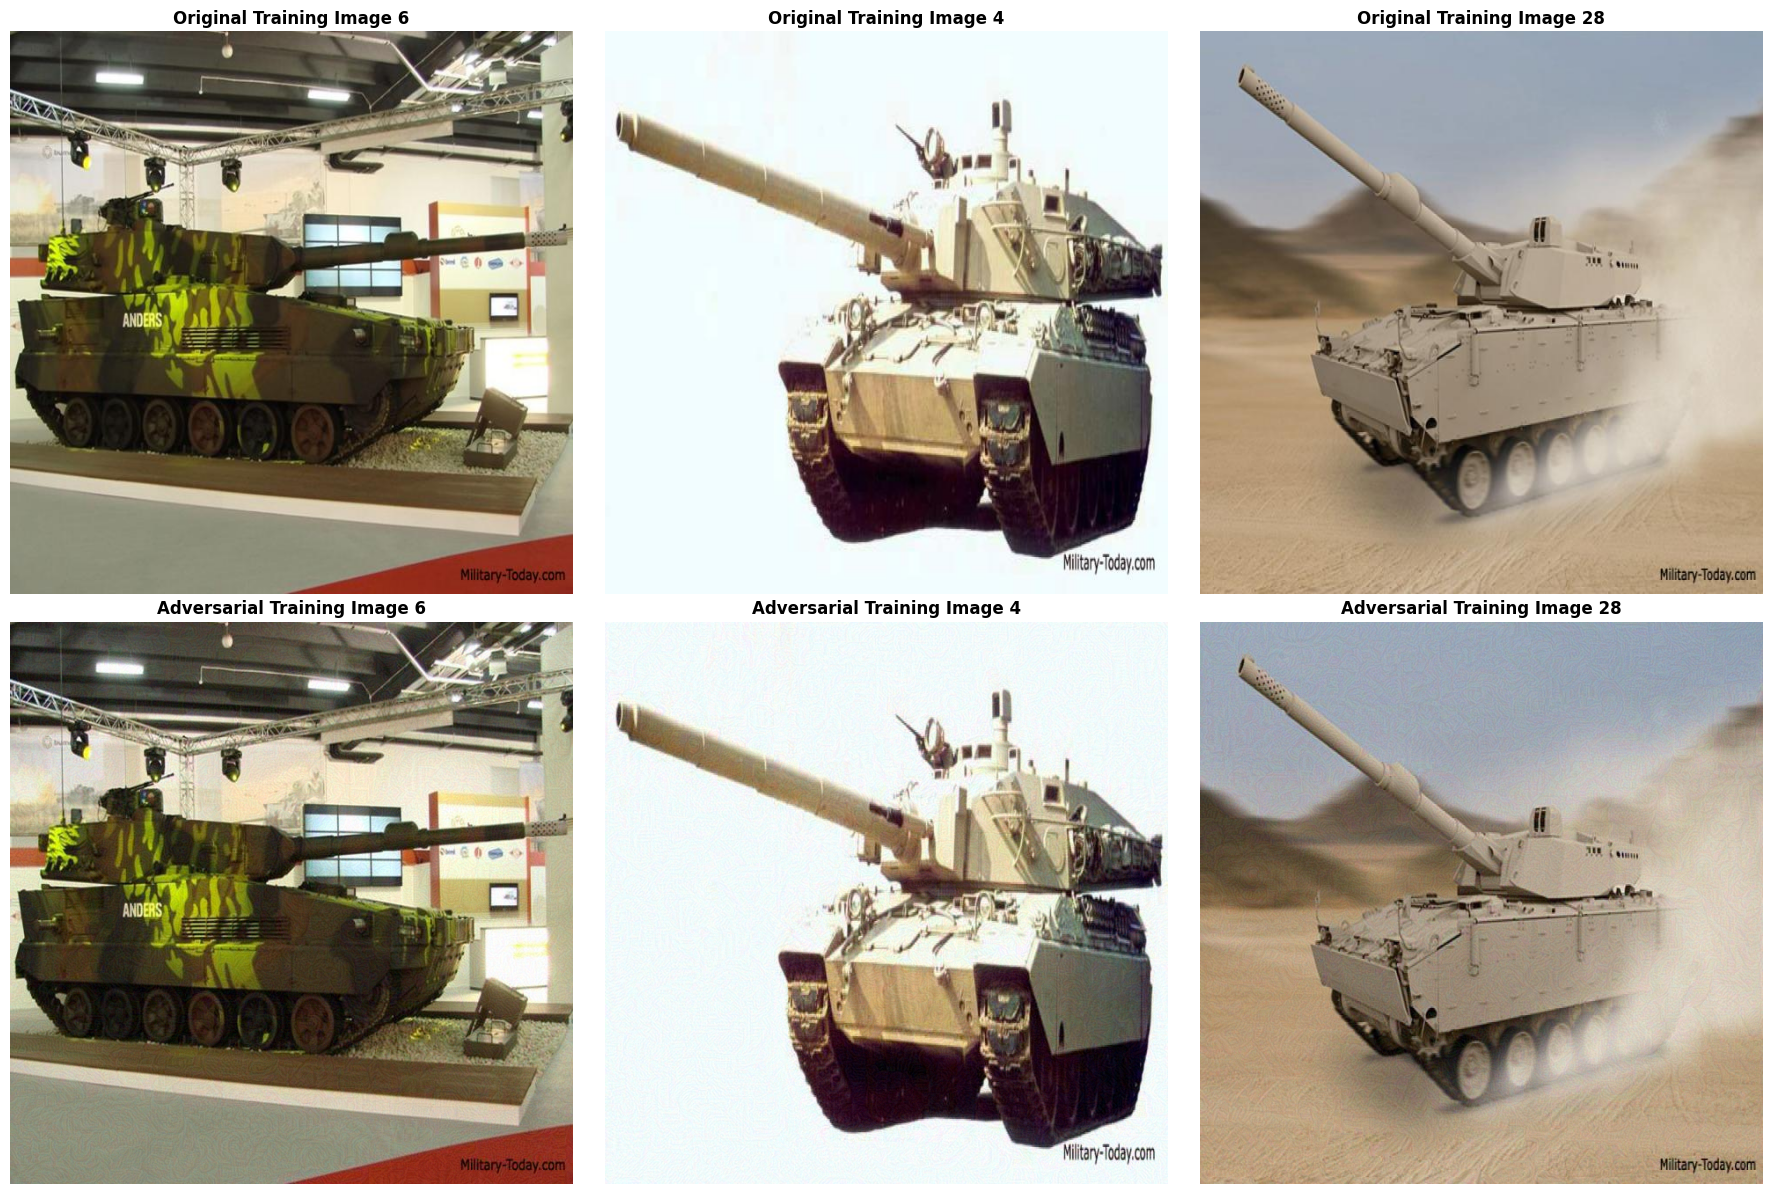

In [22]:
# 적대적 학습 데이터 샘플 시각화
print("\nVisualizing adversarial training samples...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sample_indices = np.random.choice(len(train_images), 3, replace=False)

for col, idx in enumerate(sample_indices):
    # 원본 이미지
    img_orig = train_images[idx].transpose(1, 2, 0).astype(np.uint8)
    axes[0, col].imshow(img_orig)
    axes[0, col].set_title(f"Original Training Image {idx}", fontsize=12, weight='bold')
    axes[0, col].axis('off')
    
    # 적대적 이미지
    img_adv = adversarial_train_images[idx].transpose(1, 2, 0).astype(np.uint8)
    axes[1, col].imshow(img_adv)
    axes[1, col].set_title(f"Adversarial Training Image {idx}", fontsize=12, weight='bold')
    axes[1, col].axis('off')

plt.tight_layout()
plt.show()

## 8. 적대적 데이터셋 저장 (train, val, test)

혼합 학습 데이터셋을 준비합니다:
- **Clean data (50%)**: 원본 데이터
- **Adversarial data (50%)**: PGD 공격으로 생성된 적대적 예제

In [23]:
# 적대적 데이터셋 디렉토리 구조 생성 및 저장
print("\n" + "="*70)
print("CREATING ADVERSARIAL DATASET DIRECTORY")
print("="*70)

import shutil
from PIL import Image as PILImage

# 디렉토리 생성
adv_dataset_path = Path(ADV_DATASET_PATH)

# 각 split에 대한 디렉토리 생성
splits = ['train', 'valid', 'test']
for split in splits:
    (adv_dataset_path / split / "images").mkdir(parents=True, exist_ok=True)
    (adv_dataset_path / split / "labels").mkdir(parents=True, exist_ok=True)

print(f"✓ Directory structure created at: {adv_dataset_path}\n")

# 데이터셋 저장 함수
def save_mixed_dataset(split_name, clean_images, adv_images, original_paths, original_labels_dir):
    """
    Clean + Adversarial 이미지를 저장
    """
    print(f"[{split_name.upper()}] Saving {len(clean_images)} clean + {len(adv_images)} adversarial images...")
    
    # 혼합 데이터셋 생성 (50% clean + 50% adversarial)
    mixed_images = np.concatenate([clean_images, adv_images], axis=0)
    
    images_dir = adv_dataset_path / split_name / "images"
    labels_dir = adv_dataset_path / split_name / "labels"
    
    for idx in tqdm(range(len(mixed_images)), desc=f"  Saving {split_name}"):
        img_array = mixed_images[idx]
        
        # 이미지 저장
        img_pil = PILImage.fromarray(img_array.transpose(1, 2, 0).astype(np.uint8))
        img_path = images_dir / f"{split_name}_{idx:05d}.jpg"
        img_pil.save(img_path)
        
        # 레이블 복사
        # Clean images: 0 ~ len(clean_images)-1
        # Adversarial images: len(clean_images) ~ len(mixed_images)-1
        original_idx = idx if idx < len(clean_images) else idx - len(clean_images)
        
        # 원본 레이블 파일 찾기
        original_img_name = Path(original_paths[original_idx]).stem
        original_label_file = original_labels_dir / f"{original_img_name}.txt"
        
        # 레이블 복사
        if original_label_file.exists():
            dest_label_file = labels_dir / f"{split_name}_{idx:05d}.txt"
            shutil.copy(original_label_file, dest_label_file)
        else:
            # 레이블이 없는 경우 빈 파일 생성
            dest_label_file = labels_dir / f"{split_name}_{idx:05d}.txt"
            dest_label_file.touch()
    
    print(f"  ✓ Saved {len(mixed_images)} images and labels\n")
    return len(mixed_images)

# Train 데이터 저장
train_labels_dir = Path(DATASET_PATH) / "train" / "labels"
train_total = save_mixed_dataset("train", train_images, adversarial_train_images, 
                                  train_paths, train_labels_dir)

# Validation 데이터 저장
val_labels_dir = Path(DATASET_PATH) / "valid" / "labels"
val_total = save_mixed_dataset("valid", val_images, adversarial_val_images, 
                                val_paths, val_labels_dir)

# Test 데이터 저장
test_labels_dir = Path(DATASET_PATH) / "test" / "labels"
test_total = save_mixed_dataset("test", test_images, adversarial_test_images, 
                                 test_paths, test_labels_dir)

print("="*70)
print("✅ ADVERSARIAL DATASET CREATED")
print("="*70)
print(f"\nDataset statistics:")
print(f"  Train: {train_total} images ({len(train_images)} clean + {len(adversarial_train_images)} adversarial)")
print(f"  Valid: {val_total} images ({len(val_images)} clean + {len(adversarial_val_images)} adversarial)")
print(f"  Test: {test_total} images ({len(test_images)} clean + {len(adversarial_test_images)} adversarial)")
print(f"  Total: {train_total + val_total + test_total} images")
print(f"\nDataset location: {adv_dataset_path}")


CREATING ADVERSARIAL DATASET DIRECTORY
✓ Directory structure created at: /home/jaehyun/art_train/yolo_train/art_training/defences/adv_dataset

[TRAIN] Saving 68 clean + 68 adversarial images...


  Saving train: 100%|██████████| 136/136 [00:00<00:00, 267.23it/s]


  ✓ Saved 136 images and labels

[VALID] Saving 13 clean + 13 adversarial images...


  Saving valid: 100%|██████████| 26/26 [00:00<00:00, 275.83it/s]


  ✓ Saved 26 images and labels

[TEST] Saving 13 clean + 13 adversarial images...


  Saving test: 100%|██████████| 26/26 [00:00<00:00, 272.54it/s]

  ✓ Saved 26 images and labels

✅ ADVERSARIAL DATASET CREATED

Dataset statistics:
  Train: 136 images (68 clean + 68 adversarial)
  Valid: 26 images (13 clean + 13 adversarial)
  Test: 26 images (13 clean + 13 adversarial)
  Total: 188 images

Dataset location: /home/jaehyun/art_train/yolo_train/art_training/defences/adv_dataset


## 9. data.yaml 생성

적대적 훈련을 위한 `data.yaml` 파일을 생성합니다.

In [24]:
# data.yaml 생성
print("\n" + "="*70)
print("CREATING DATA.YAML FOR ADVERSARIAL TRAINING")
print("="*70)

# 적대적 데이터셋의 data.yaml 설정
adv_data_config = {
    'path': str(adv_dataset_path.resolve()),  # 절대 경로
    'train': 'train/images',  # path 기준 상대 경로
    'val': 'valid/images',
    'test': 'test/images',
    'nc': data_config['nc'],
    'names': data_config['names']
}

# data.yaml 저장
adv_data_yaml_path = adv_dataset_path / "data.yaml"
with open(adv_data_yaml_path, 'w') as f:
    yaml.dump(adv_data_config, f, default_flow_style=False, sort_keys=False)

print(f"✓ data.yaml created at: {adv_data_yaml_path}\n")
print("Configuration:")
print(f"  path: {adv_data_config['path']}")
print(f"  train: {adv_data_config['train']}")
print(f"  val: {adv_data_config['val']}")
print(f"  test: {adv_data_config['test']}")
print(f"  nc: {adv_data_config['nc']}")
print(f"  names: {adv_data_config['names']}")

# 검증: 파일 존재 확인
print(f"\n✓ Verifying dataset files...")
for split in ['train', 'valid', 'test']:
    img_dir = adv_dataset_path / split / "images"
    lbl_dir = adv_dataset_path / split / "labels"
    num_images = len(list(img_dir.glob("*.jpg")))
    num_labels = len(list(lbl_dir.glob("*.txt")))
    print(f"  {split}: {num_images} images, {num_labels} labels")

print(f"\n✅ Dataset ready for training!")


CREATING DATA.YAML FOR ADVERSARIAL TRAINING
✓ data.yaml created at: /home/jaehyun/art_train/yolo_train/art_training/defences/adv_dataset/data.yaml

Configuration:
  path: /home/jaehyun/art_train/yolo_train/art_training/defences/adv_dataset
  train: train/images
  val: valid/images
  test: test/images
  nc: 1
  names: {0: 'Tank'}

✓ Verifying dataset files...
  train: 136 images, 136 labels
  valid: 26 images, 26 labels
  test: 26 images, 26 labels

✅ Dataset ready for training!


## 10. 적대적 훈련 수행

생성된 적대적 데이터셋으로 YOLOv8 모델을 재학습합니다.

In [25]:
# 적대적 훈련 수행
print("\n" + "="*70)
print("ADVERSARIAL TRAINING WITH ULTRALYTICS")
print("="*70)

print(f"\nTraining configuration:")
print(f"  Data: {adv_data_yaml_path}")
print(f"  Base model: {ORIGINAL_MODEL_PATH}")
print(f"  Epochs: 100")
print(f"  Image size: 640")
print(f"  Batch size: 16")
print(f"  Device: {device}")
print(f"\nDataset:")
print(f"  Train: {train_total} images (50% clean + 50% adversarial)")
print(f"  Val: {val_total} images (50% clean + 50% adversarial)")

# 새로운 YOLO 모델 인스턴스 (원본 가중치 로드)
print(f"\n{'='*70}")
print("Starting training...")
print(f"{'='*70}\n")

adv_model = YOLO(ORIGINAL_MODEL_PATH)

# 적대적 훈련 실행
results = adv_model.train(
    data=str(adv_data_yaml_path),
    epochs=100,
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else 'cpu',
    project=str(Path(DEFENDED_MODEL_SAVE_PATH).parent),
    name='adversarial_training',
    exist_ok=True,
    verbose=True,
    patience=10,
    save=True,
    plots=True
)

print(f"\n{'='*70}")
print("✅ ADVERSARIAL TRAINING COMPLETED")
print(f"{'='*70}")

# 학습된 모델 저장
trained_model_path = Path(DEFENDED_MODEL_SAVE_PATH).parent / "adversarial_training" / "weights" / "best.pt"

if trained_model_path.exists():
    import shutil
    shutil.copy(trained_model_path, DEFENDED_MODEL_SAVE_PATH)
    print(f"\n✓ Model saved to: {DEFENDED_MODEL_SAVE_PATH}")
    
    # 학습된 모델 로드
    defended_yolo = YOLO(DEFENDED_MODEL_SAVE_PATH)
    defended_model = defended_yolo.model
    defended_model.to(device)
    defended_model.eval()
    
    print(f"✓ Model loaded for evaluation")
else:
    print(f"\n⚠ Warning: Trained model not found at {trained_model_path}")
    defended_model = model
    defended_model.eval()


ADVERSARIAL TRAINING WITH ULTRALYTICS

Training configuration:
  Data: /home/jaehyun/art_train/yolo_train/art_training/defences/adv_dataset/data.yaml
  Base model: /home/jaehyun/art_train/yolo_train/runs/detect/train_only_tank/weights/best.pt
  Epochs: 100
  Image size: 640
  Batch size: 16
  Device: cuda

Dataset:
  Train: 136 images (50% clean + 50% adversarial)
  Val: 26 images (50% clean + 50% adversarial)

Starting training...

New https://pypi.org/project/ultralytics/8.3.218 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.196 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5080, 16303MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jaehyun/art_train/yolo_train/art_training/defences/adv_dataset/data.yaml, degrees=0.

## 11. 방어 모델 평가

### 11.1 Clean 데이터 성능 평가 (Validation Set)

In [26]:
# 방어 모델 - Clean 데이터 성능 평가
print("\n" + "="*70)
print("EVALUATION ON CLEAN VALIDATION DATA")
print("="*70)

# 방어 모델용 ART Estimator 생성
detector_defended = PyTorchYolo(
    model=defended_model,
    device_type='cuda' if torch.cuda.is_available() else 'cpu',
    input_shape=INPUT_SHAPE,
    clip_values=(0, 255),
    channels_first=True,
    attack_losses=("loss_total", "loss_cls", "loss_box", "loss_dfl"),
    is_ultralytics=True,
    model_name="yolov8n"
)

# Clean validation 데이터 평가
print("\n[Original Model] Evaluating on clean validation data...")
clean_pred_original = detector_original.predict(val_images)
metrics_original_clean = calculate_detection_metrics(clean_pred_original)

print("\n[Defended Model] Evaluating on clean validation data...")
clean_pred_defended = detector_defended.predict(val_images)
metrics_defended_clean = calculate_detection_metrics(clean_pred_defended)

# 결과 출력
print("\n" + "-"*70)
print("RESULTS: CLEAN VALIDATION DATA")
print("-"*70)

print("\nOriginal Model:")
print(f"  Total detections: {metrics_original_clean['total_detections']}")
print(f"  Average confidence: {metrics_original_clean['avg_confidence']:.4f}")
print(f"  Detections per image: {metrics_original_clean['total_detections']/metrics_original_clean['num_images']:.2f}")

print("\nDefended Model:")
print(f"  Total detections: {metrics_defended_clean['total_detections']}")
print(f"  Average confidence: {metrics_defended_clean['avg_confidence']:.4f}")
print(f"  Detections per image: {metrics_defended_clean['total_detections']/metrics_defended_clean['num_images']:.2f}")

# 성능 변화
if metrics_original_clean['total_detections'] > 0:
    performance_change = ((metrics_defended_clean['total_detections'] / metrics_original_clean['total_detections']) - 1) * 100
    print(f"\nPerformance change: {performance_change:+.1f}%")
    
    if abs(performance_change) <= 5:
        print("✅ Clean data performance maintained excellently!")
    elif abs(performance_change) <= 10:
        print("✓ Clean data performance maintained well")
    else:
        print("⚠ Noticeable clean data performance change")


EVALUATION ON CLEAN VALIDATION DATA

[Original Model] Evaluating on clean validation data...

[Defended Model] Evaluating on clean validation data...

----------------------------------------------------------------------
RESULTS: CLEAN VALIDATION DATA
----------------------------------------------------------------------

Original Model:
  Total detections: 0
  Average confidence: 0.0000
  Detections per image: 0.00

Defended Model:
  Total detections: 14
  Average confidence: 0.6739
  Detections per image: 1.08


### 11.2 Adversarial 데이터 성능 평가 (Validation Set)

Validation set에 대해 적대적 예제를 생성하고, 원본 모델과 방어 모델의 성능을 비교합니다.

In [27]:
# Validation Set에 대한 적대적 성능 평가
print("\n" + "="*70)
print("EVALUATION ON ADVERSARIAL VALIDATION DATA")
print("="*70)

# Validation 데이터에 대한 적대적 예제 생성 (평가용 - 더 강한 공격)
pgd_val_eval_params = {
    'norm': np.inf,
    'eps': 8.0,  # 학습용 섭동 크기
    'eps_step': 2.0,
    'max_iter': 100,
    'targeted': False,
    'batch_size': 4,
    'verbose': True
}


print("\n[1/4] Generating adversarial validation examples...")
print(f"Attack parameters: eps={pgd_val_eval_params['eps']}, max_iter={pgd_val_eval_params['max_iter']}")

pgd_val_eval = ProjectedGradientDescent(
    estimator=detector_original,
    **pgd_val_eval_params
)

# Validation 적대적 예제 생성
adversarial_val_eval = pgd_val_eval.generate(x=val_images, y=y_val)

print(f"\n✓ Adversarial validation images generated!")
print(f"Shape: {adversarial_val_eval.shape}")

# 섭동 통계
val_perturbations = adversarial_val_eval - val_images
print(f"Perturbation statistics:")
print(f"  Mean absolute: {np.mean(np.abs(val_perturbations)):.4f}")
print(f"  Max absolute: {np.max(np.abs(val_perturbations)):.4f}")

# 원본 모델 평가
print("\n[2/4] Evaluating original model on adversarial validation data...")
adv_val_pred_original = detector_original.predict(adversarial_val_eval)
metrics_val_adv_original = calculate_detection_metrics(adv_val_pred_original)

# 방어 모델 평가
print("\n[3/4] Evaluating defended model on adversarial validation data...")
adv_val_pred_defended = detector_defended.predict(adversarial_val_eval)
metrics_val_adv_defended = calculate_detection_metrics(adv_val_pred_defended)

# 결과 비교
print("\n[4/4] Results summary")
print("\n" + "-"*70)
print("RESULTS: ADVERSARIAL VALIDATION DATA")
print("-"*70)

print("\n📊 Original Model (on adversarial validation):")
print(f"  Total detections: {metrics_val_adv_original['total_detections']}")
print(f"  Average confidence: {metrics_val_adv_original['avg_confidence']:.4f}")
print(f"  Detections per image: {metrics_val_adv_original['total_detections']/metrics_val_adv_original['num_images']:.2f}")

print("\n📊 Defended Model (on adversarial validation):")
print(f"  Total detections: {metrics_val_adv_defended['total_detections']}")
print(f"  Average confidence: {metrics_val_adv_defended['avg_confidence']:.4f}")
print(f"  Detections per image: {metrics_val_adv_defended['total_detections']/metrics_val_adv_defended['num_images']:.2f}")

# Robustness 계산
print("\n📈 Robustness Analysis (Validation Set):")

# 원본 모델의 robustness rate (clean 대비 adversarial)
if metrics_original_clean['total_detections'] > 0:
    original_val_robust_rate = (metrics_val_adv_original['total_detections'] / 
                                 metrics_original_clean['total_detections']) * 100
    print(f"  Original model robustness: {original_val_robust_rate:.1f}%")
    print(f"  Original model attack success rate: {100 - original_val_robust_rate:.1f}%")

# 방어 모델의 robustness rate
if metrics_defended_clean['total_detections'] > 0:
    defended_val_robust_rate = (metrics_val_adv_defended['total_detections'] / 
                                 metrics_defended_clean['total_detections']) * 100
    print(f"  Defended model robustness: {defended_val_robust_rate:.1f}%")
    print(f"  Defended model attack success rate: {100 - defended_val_robust_rate:.1f}%")

# 개선도 계산
if metrics_val_adv_original['total_detections'] > 0:
    val_detection_improvement = ((metrics_val_adv_defended['total_detections'] - 
                                  metrics_val_adv_original['total_detections']) / 
                                 metrics_val_adv_original['total_detections'] * 100)
    print(f"\n  Detection improvement on adversarial data: {val_detection_improvement:+.1f}%")
    
    robustness_gain = defended_val_robust_rate - original_val_robust_rate
    print(f"  Robustness gain: {robustness_gain:+.1f}% points")
    
    # 성능 평가
    print("\n" + "="*70)
    if val_detection_improvement > 30:
        print("✅ EXCELLENT: Significant robustness improvement on validation set!")
    elif val_detection_improvement > 15:
        print("✓ GOOD: Notable robustness improvement on validation set")
    elif val_detection_improvement > 0:
        print("✓ MODERATE: Some robustness improvement on validation set")
    else:
        print("⚠ LIMITED: Robustness improvement is limited on validation set")
    print("="*70)
else:
    print("\n  Original model completely failed on adversarial validation data")
    print(f"  Defended model recovered {metrics_val_adv_defended['total_detections']} detections")
    print("\n✅ EXCELLENT: Complete recovery from adversarial attack on validation set!")


EVALUATION ON ADVERSARIAL VALIDATION DATA

[1/4] Generating adversarial validation examples...
Attack parameters: eps=8.0, max_iter=100


PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]


✓ Adversarial validation images generated!
Shape: (13, 3, 640, 640)
Perturbation statistics:
  Mean absolute: 4.6646
  Max absolute: 8.0000

[2/4] Evaluating original model on adversarial validation data...

[3/4] Evaluating defended model on adversarial validation data...

[4/4] Results summary

----------------------------------------------------------------------
RESULTS: ADVERSARIAL VALIDATION DATA
----------------------------------------------------------------------

📊 Original Model (on adversarial validation):
  Total detections: 51
  Average confidence: 0.9085
  Detections per image: 3.92

📊 Defended Model (on adversarial validation):
  Total detections: 13
  Average confidence: 0.6782
  Detections per image: 1.00

📈 Robustness Analysis (Validation Set):
  Defended model robustness: 92.9%
  Defended model attack success rate: 7.1%

  Detection improvement on adversarial data: -74.5%


NameError: name 'original_val_robust_rate' is not defined


Visualizing validation set performance...



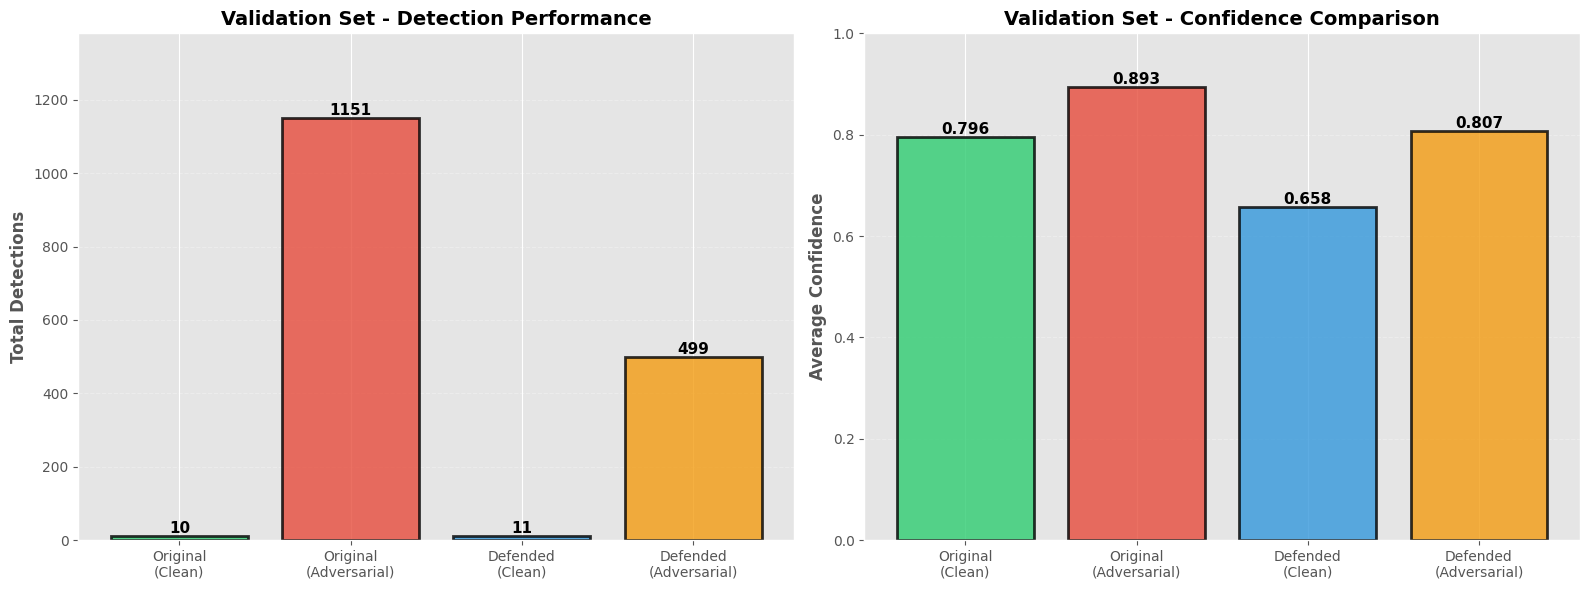


Sample comparison (Original vs Adversarial):



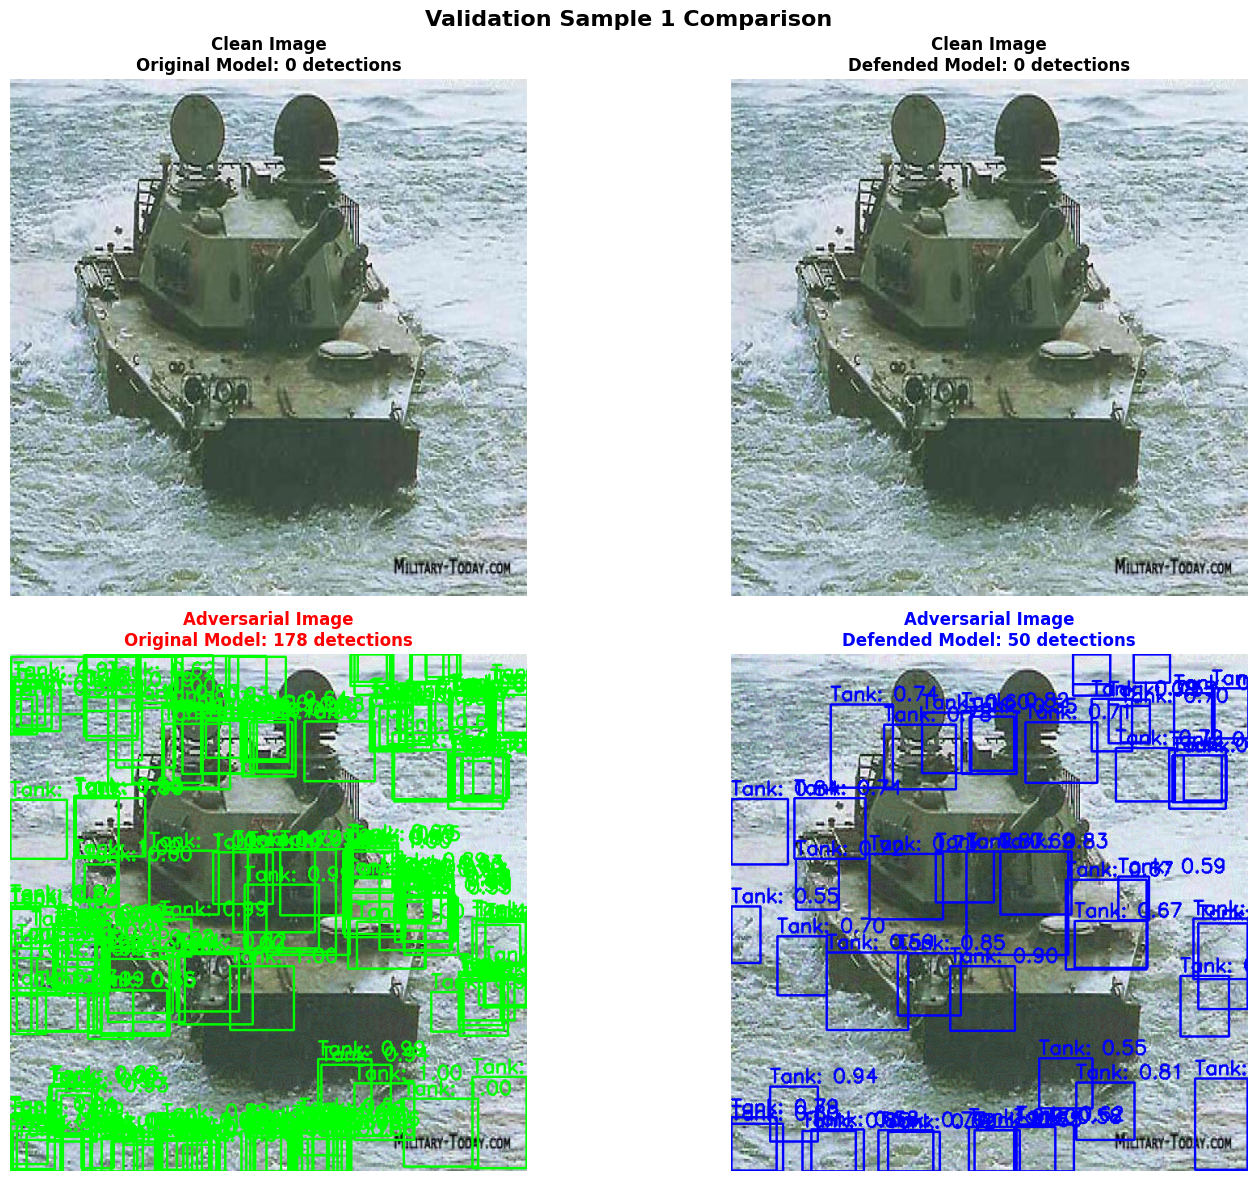

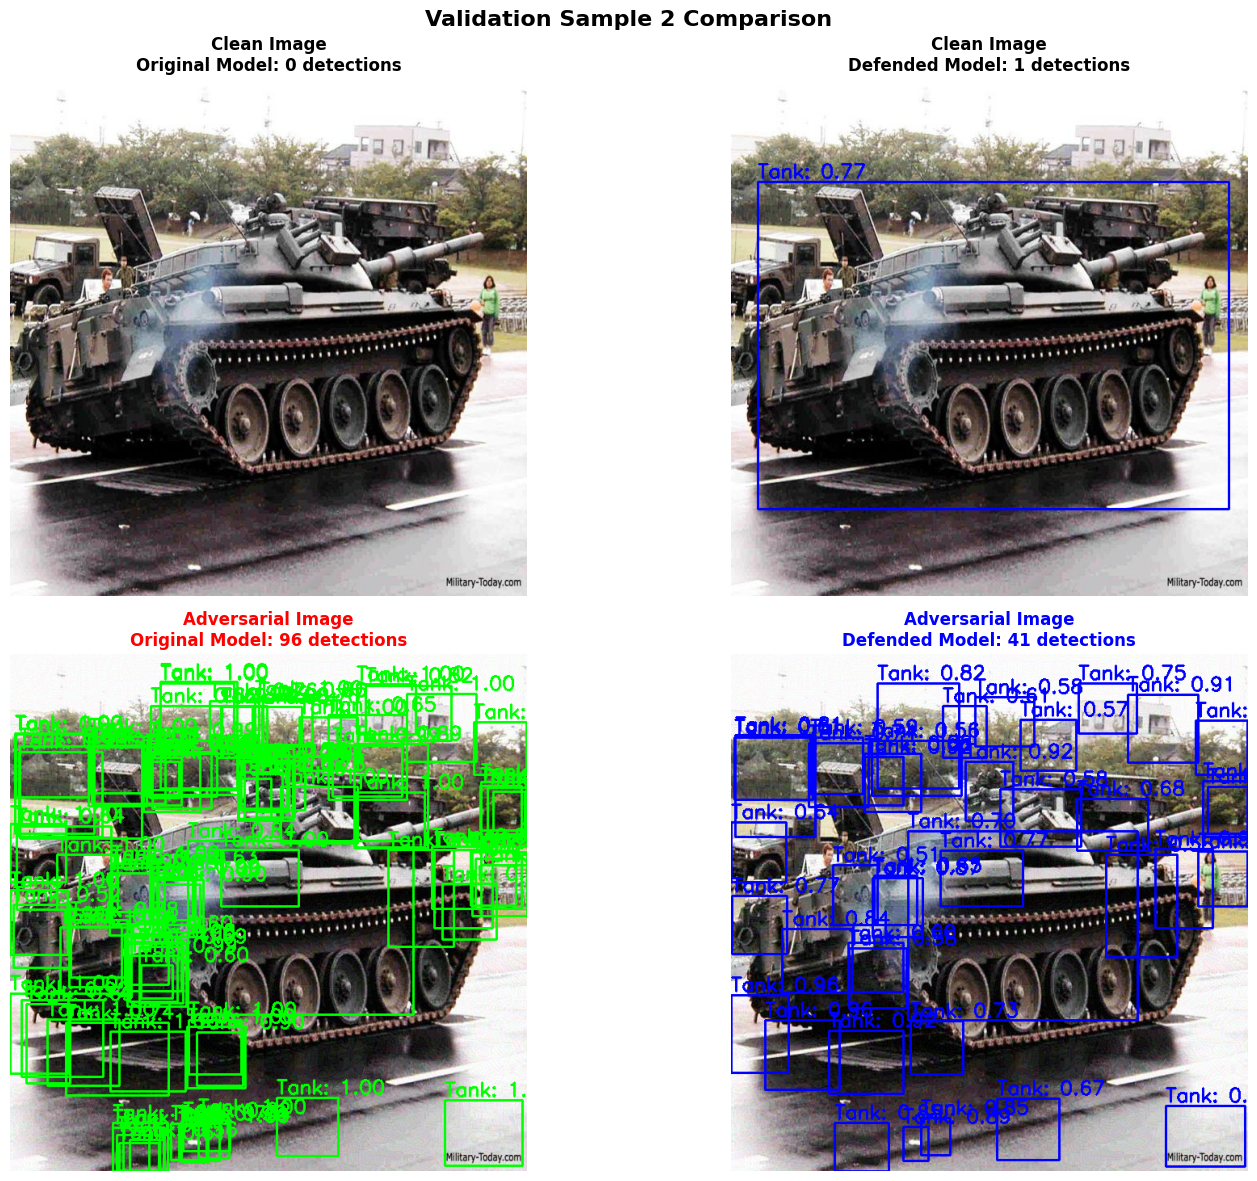

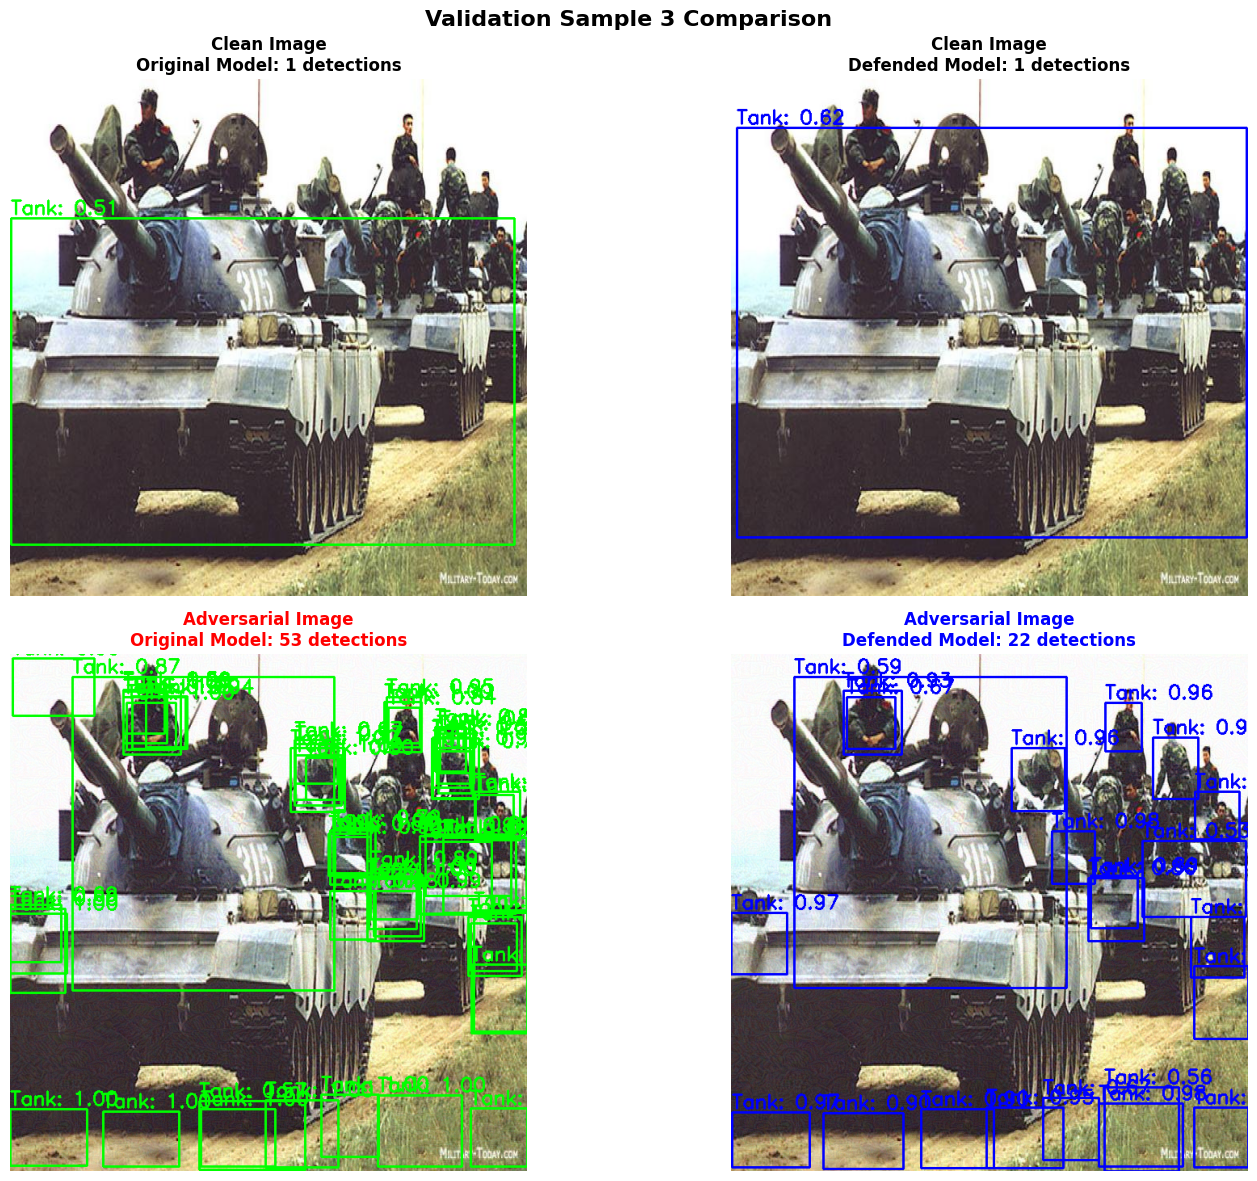

In [ ]:
# Validation Set 결과 시각화
print("\nVisualizing validation set performance...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Validation Set - Detection Count 비교
val_models = ['Original\n(Clean)', 'Original\n(Adversarial)', 'Defended\n(Clean)', 'Defended\n(Adversarial)']
val_detections = [
    metrics_original_clean['total_detections'],
    metrics_val_adv_original['total_detections'],
    metrics_defended_clean['total_detections'],
    metrics_val_adv_defended['total_detections']
]
val_colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']

bars1 = axes[0].bar(val_models, val_detections, color=val_colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Total Detections', fontsize=12, weight='bold')
axes[0].set_title('Validation Set - Detection Performance', fontsize=14, weight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim([0, max(val_detections) * 1.2])

for bar in bars1:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2., height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=11, weight='bold'
    )

# 2. Validation Set - Confidence Score 비교
val_confidences = [
    metrics_original_clean['avg_confidence'],
    metrics_val_adv_original['avg_confidence'],
    metrics_defended_clean['avg_confidence'],
    metrics_val_adv_defended['avg_confidence']
]

bars2 = axes[1].bar(val_models, val_confidences, color=val_colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Average Confidence', fontsize=12, weight='bold')
axes[1].set_title('Validation Set - Confidence Comparison', fontsize=14, weight='bold')
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars2:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2., height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=11, weight='bold'
    )

plt.tight_layout()
plt.show()

# 샘플 이미지 비교 시각화
print("\nSample comparison (Original vs Adversarial):\n")

for idx in (0,len(val_images)):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 원본 이미지 - 원본 모델
    img_clean = val_images[idx].transpose(1, 2, 0).copy()
    preds_clean_orig = extract_predictions(clean_pred_original[idx], conf_thresh=0.5)
    
    for box, label, score in zip(preds_clean_orig[1], preds_clean_orig[0], preds_clean_orig[2]):
        cv2.rectangle(img_clean, 
                     (int(box[0][0]), int(box[0][1])), 
                     (int(box[1][0]), int(box[1][1])),
                     color=(0, 255, 0), thickness=2)
        cv2.putText(img_clean, f"{label}: {score:.2f}", 
                   (int(box[0][0]), int(box[0][1]) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), thickness=2)
    
    axes[0, 0].imshow(img_clean.astype(np.uint8))
    axes[0, 0].set_title(f"Clean Image\nOriginal Model: {len(preds_clean_orig[0])} detections", 
                        fontsize=12, weight='bold')
    axes[0, 0].axis('off')
    
    # 원본 이미지 - 방어 모델
    img_clean2 = val_images[idx].transpose(1, 2, 0).copy()
    preds_clean_def = extract_predictions(clean_pred_defended[idx], conf_thresh=0.5)
    
    for box, label, score in zip(preds_clean_def[1], preds_clean_def[0], preds_clean_def[2]):
        cv2.rectangle(img_clean2, 
                     (int(box[0][0]), int(box[0][1])), 
                     (int(box[1][0]), int(box[1][1])),
                     color=(0, 0, 255), thickness=2)
        cv2.putText(img_clean2, f"{label}: {score:.2f}", 
                   (int(box[0][0]), int(box[0][1]) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), thickness=2)
    
    axes[0, 1].imshow(img_clean2.astype(np.uint8))
    axes[0, 1].set_title(f"Clean Image\nDefended Model: {len(preds_clean_def[0])} detections", 
                        fontsize=12, weight='bold')
    axes[0, 1].axis('off')
    
    # 적대적 이미지 - 원본 모델
    img_adv = adversarial_val_eval[idx].transpose(1, 2, 0).copy()
    preds_adv_orig = extract_predictions(adv_val_pred_original[idx], conf_thresh=0.5)
    
    for box, label, score in zip(preds_adv_orig[1], preds_adv_orig[0], preds_adv_orig[2]):
        cv2.rectangle(img_adv, 
                     (int(box[0][0]), int(box[0][1])), 
                     (int(box[1][0]), int(box[1][1])),
                     color=(0, 255, 0), thickness=2)
        cv2.putText(img_adv, f"{label}: {score:.2f}", 
                   (int(box[0][0]), int(box[0][1]) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), thickness=2)
    
    axes[1, 0].imshow(img_adv.astype(np.uint8))
    axes[1, 0].set_title(f"Adversarial Image\nOriginal Model: {len(preds_adv_orig[0])} detections", 
                        fontsize=12, weight='bold', color='red')
    axes[1, 0].axis('off')
    
    # 적대적 이미지 - 방어 모델
    img_adv2 = adversarial_val_eval[idx].transpose(1, 2, 0).copy()
    preds_adv_def = extract_predictions(adv_val_pred_defended[idx], conf_thresh=0.5)
    
    for box, label, score in zip(preds_adv_def[1], preds_adv_def[0], preds_adv_def[2]):
        cv2.rectangle(img_adv2, 
                     (int(box[0][0]), int(box[0][1])), 
                     (int(box[1][0]), int(box[1][1])),
                     color=(0, 0, 255), thickness=2)
        cv2.putText(img_adv2, f"{label}: {score:.2f}", 
                   (int(box[0][0]), int(box[0][1]) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), thickness=2)
    
    axes[1, 1].imshow(img_adv2.astype(np.uint8))
    axes[1, 1].set_title(f"Adversarial Image\nDefended Model: {len(preds_adv_def[0])} detections", 
                        fontsize=12, weight='bold', color='blue')
    axes[1, 1].axis('off')
    
    fig.suptitle(f"Validation Sample {idx+1} Comparison", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
# Test 데이터에 대한 PGD 공격 생성
print("\n" + "="*70)
print("GENERATING ADVERSARIAL TEST EXAMPLES (STRONGER ATTACK)")
print("="*70)

pgd_eval_params = {
    'norm': np.inf,
    'eps': 8.0,  # 평가용은 더 강한 공격 (학습: 8.0)
    'eps_step': 2.0,
    'max_iter': 100,  # 더 많은 반복 
    'targeted': False,
    'batch_size': 4,
    'num_random_init': 0,
    'verbose': True
}

print(f"\nAttack parameters:")
print(f"  Epsilon: {pgd_eval_params['eps']} (training used: 8.0)")
print(f"  Max iterations: {pgd_eval_params['max_iter']} (training used: 10)")
print(f"  This is a STRONGER attack than used in training")

pgd_eval_attack = ProjectedGradientDescent(
    estimator=detector_original,
    **pgd_eval_params
)

# Test 데이터에 대한 적대적 예제 생성
print(f"\nGenerating adversarial test examples for {len(test_images)} images...")
adversarial_test_eval = pgd_eval_attack.generate(x=test_images, y=y_test)

print(f"\n✓ Adversarial test images generated!")
print(f"Shape: {adversarial_test_eval.shape}")

# 섭동 통계
perturbations = adversarial_test_eval - test_images
print(f"\nPerturbation statistics:")
print(f"  Mean absolute: {np.mean(np.abs(perturbations)):.4f}")
print(f"  Max absolute: {np.max(np.abs(perturbations)):.4f}")


GENERATING ADVERSARIAL TEST EXAMPLES (STRONGER ATTACK)

Attack parameters:
  Epsilon: 8.0 (training used: 8.0)
  Max iterations: 100 (training used: 10)
  This is a STRONGER attack than used in training

Generating adversarial test examples for 13 images...


PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Iterations: 100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


✓ Adversarial test images generated!
Shape: (13, 3, 640, 640)

Perturbation statistics:
  Mean absolute: 5.1297
  Max absolute: 8.0000


## 12. 성능 비교 시각화

In [ ]:

# 적대적 Test 데이터에 대한 평가
print("\n" + "="*70)
print("EVALUATION ON ADVERSARIAL TEST DATA")
print("="*70)

# Clean test 데이터 베이스라인
print("\n[1/3] Evaluating on clean test data (baseline)...")
clean_test_pred_original = detector_original.predict(test_images)
metrics_test_clean_original = calculate_detection_metrics(clean_test_pred_original)

clean_test_pred_defended = detector_defended.predict(test_images)
metrics_test_clean_defended = calculate_detection_metrics(clean_test_pred_defended)

print(f"✓ Original model (clean test): {metrics_test_clean_original['total_detections']} detections")
print(f"✓ Defended model (clean test): {metrics_test_clean_defended['total_detections']} detections")

# Adversarial test 데이터 평가
print("\n[2/3] Evaluating on adversarial test data...")
adv_test_pred_original = detector_original.predict(adversarial_test_eval)
metrics_test_adv_original = calculate_detection_metrics(adv_test_pred_original)

adv_test_pred_defended = detector_defended.predict(adversarial_test_eval)
metrics_test_adv_defended = calculate_detection_metrics(adv_test_pred_defended)

print(f"✓ Original model (adversarial test): {metrics_test_adv_original['total_detections']} detections")
print(f"✓ Defended model (adversarial test): {metrics_test_adv_defended['total_detections']} detections")

# 결과 출력
print("\n[3/3] Results summary")
print("\n" + "="*70)
print("ADVERSARIAL ROBUSTNESS COMPARISON")
print("="*70)

print("\n📊 Original Model:")
print(f"  Clean test: {metrics_test_clean_original['total_detections']} detections, "
      f"confidence: {metrics_test_clean_original['avg_confidence']:.4f}")
print(f"  Adversarial test: {metrics_test_adv_original['total_detections']} detections, "
      f"confidence: {metrics_test_adv_original['avg_confidence']:.4f}")
if metrics_test_clean_original['total_detections'] > 0:
    original_robust_rate = (metrics_test_adv_original['total_detections'] / 
                           metrics_test_clean_original['total_detections']) * 100
    print(f"  Robustness rate: {original_robust_rate:.1f}%")
    print(f"  Attack success rate: {100 - original_robust_rate:.1f}%")

print("\n📊 Defended Model:")
print(f"  Clean test: {metrics_test_clean_defended['total_detections']} detections, "
      f"confidence: {metrics_test_clean_defended['avg_confidence']:.4f}")
print(f"  Adversarial test: {metrics_test_adv_defended['total_detections']} detections, "
      f"confidence: {metrics_test_adv_defended['avg_confidence']:.4f}")
if metrics_test_clean_defended['total_detections'] > 0:
    defended_robust_rate = (metrics_test_adv_defended['total_detections'] / 
                           metrics_test_clean_defended['total_detections']) * 100
    print(f"  Robustness rate: {defended_robust_rate:.1f}%")
    print(f"  Attack success rate: {100 - defended_robust_rate:.1f}%")

# 개선도 계산
print("\n📈 Improvement:")
if metrics_test_adv_original['total_detections'] > 0:
    detection_improvement = ((metrics_test_adv_defended['total_detections'] - 
                             metrics_test_adv_original['total_detections']) / 
                            metrics_test_adv_original['total_detections'] * 100)
    print(f"  Detection improvement: {detection_improvement:+.1f}%")
    
    robustness_improvement = defended_robust_rate - original_robust_rate
    print(f"  Robustness improvement: {robustness_improvement:+.1f}% points")
    
    if detection_improvement > 30:
        print("\n✅ EXCELLENT: Significant robustness improvement achieved!")
    elif detection_improvement > 15:
        print("\n✓ GOOD: Notable robustness improvement")
    elif detection_improvement > 0:
        print("\n✓ MODERATE: Some robustness improvement")
    else:
        print("\n⚠ LIMITED: Consider longer training or stronger augmentation")
else:
    print(f"  Original model completely failed on adversarial data")
    print(f"  Defended model recovered {metrics_test_adv_defended['total_detections']} detections")
    print("\n✅ EXCELLENT: Complete recovery from adversarial attack!")


EVALUATION ON ADVERSARIAL TEST DATA

[1/3] Evaluating on clean test data (baseline)...
✓ Original model (clean test): 12 detections
✓ Defended model (clean test): 13 detections

[2/3] Evaluating on adversarial test data...
✓ Original model (adversarial test): 1226 detections
✓ Defended model (adversarial test): 502 detections

[3/3] Results summary

ADVERSARIAL ROBUSTNESS COMPARISON

📊 Original Model:
  Clean test: 12 detections, confidence: 0.8180
  Adversarial test: 1226 detections, confidence: 0.8931
  Robustness rate: 10216.7%
  Attack success rate: -10116.7%

📊 Defended Model:
  Clean test: 13 detections, confidence: 0.6858
  Adversarial test: 502 detections, confidence: 0.8028
  Robustness rate: 3861.5%
  Attack success rate: -3761.5%

📈 Improvement:
  Detection improvement: -59.1%
  Robustness improvement: -6355.1% points

⚠ LIMITED: Consider longer training or stronger augmentation


# 모델 강건성 비교 시각화

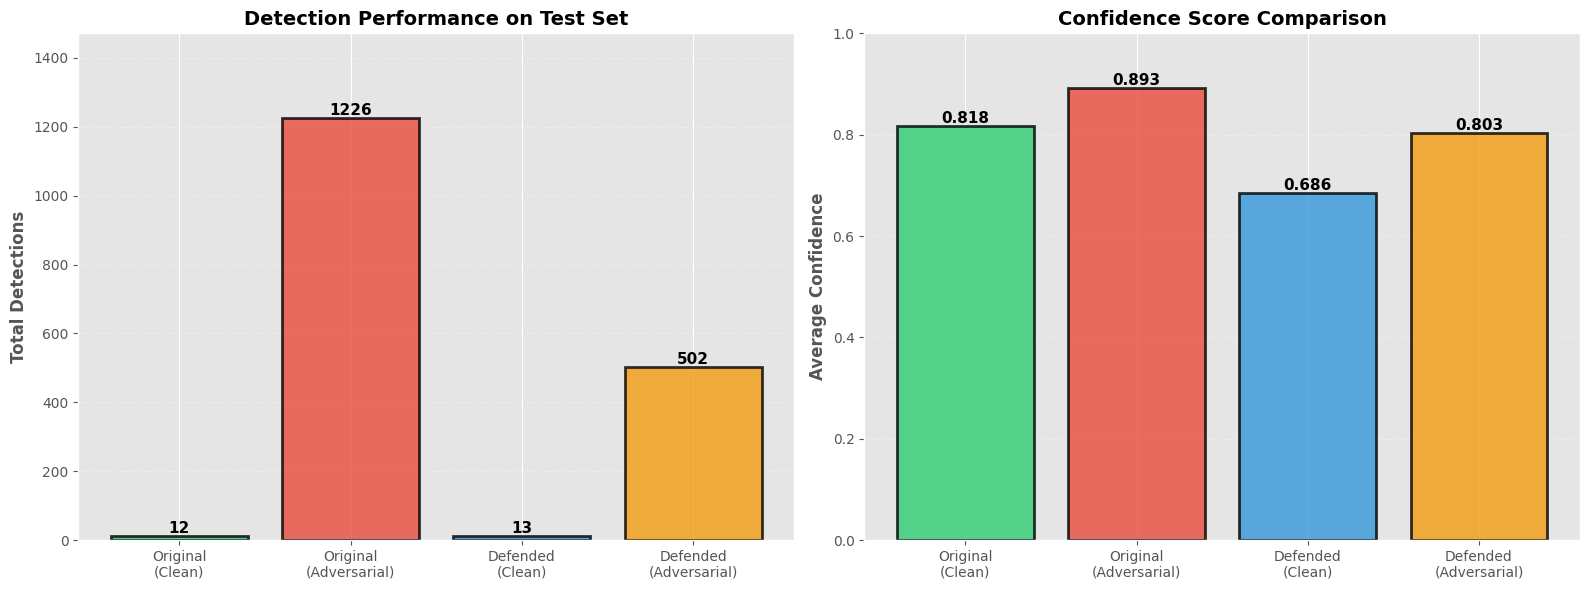


FINAL PERFORMANCE SUMMARY

📊 Test Set - Detection Count:
  Original (Clean): 12
  Original (Adversarial): 1226 (10216.7%)
  Defended (Clean): 13 (108.3%)
  Defended (Adversarial): 502 (4183.3%)

📈 Key Metrics:
  Adversarial robustness gain: -59.1%
  Clean data impact: +8.3%
  Attack success rate (Original): -10116.7%
  Attack success rate (Defended): -3761.5%

⚠ LIMITED: Consider longer training or hyperparameter tuning


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Detection Count 비교
models = ['Original\n(Clean)', 'Original\n(Adversarial)', 'Defended\n(Clean)', 'Defended\n(Adversarial)']
detections = [
    metrics_test_clean_original['total_detections'],
    metrics_test_adv_original['total_detections'],
    metrics_test_clean_defended['total_detections'],
    metrics_test_adv_defended['total_detections']
]
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']

bars1 = axes[0].bar(models, detections, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Total Detections', fontsize=12, weight='bold')
axes[0].set_title('Detection Performance on Test Set', fontsize=14, weight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim([0, max(detections) * 1.2])

for bar in bars1:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2., height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=11, weight='bold'
    )

# 2. Confidence Score 비교
confidences = [
    metrics_test_clean_original['avg_confidence'],
    metrics_test_adv_original['avg_confidence'],
    metrics_test_clean_defended['avg_confidence'],
    metrics_test_adv_defended['avg_confidence']
]

bars2 = axes[1].bar(models, confidences, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Average Confidence', fontsize=12, weight='bold')
axes[1].set_title('Confidence Score Comparison', fontsize=14, weight='bold')
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars2:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2., height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=11, weight='bold'
    )

plt.tight_layout()
plt.show()

# 통계 요약
print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)

print("\n📊 Test Set - Detection Count:")
print(f"  Original (Clean): {metrics_test_clean_original['total_detections']}")
print(f"  Original (Adversarial): {metrics_test_adv_original['total_detections']} "
      f"({metrics_test_adv_original['total_detections']/metrics_test_clean_original['total_detections']*100:.1f}%)")
print(f"  Defended (Clean): {metrics_test_clean_defended['total_detections']} "
      f"({metrics_test_clean_defended['total_detections']/metrics_test_clean_original['total_detections']*100:.1f}%)")
print(f"  Defended (Adversarial): {metrics_test_adv_defended['total_detections']} "
      f"({metrics_test_adv_defended['total_detections']/metrics_test_clean_original['total_detections']*100:.1f}%)")

print("\n📈 Key Metrics:")
if metrics_test_adv_original['total_detections'] > 0:
    robust_improvement = ((metrics_test_adv_defended['total_detections'] - 
                          metrics_test_adv_original['total_detections']) /
                         metrics_test_adv_original['total_detections'] * 100)
else:
    robust_improvement = float('inf')

clean_impact = ((metrics_test_clean_defended['total_detections'] - 
                metrics_test_clean_original['total_detections']) /
               metrics_test_clean_original['total_detections'] * 100) if metrics_test_clean_original['total_detections'] > 0 else 0

print(f"  Adversarial robustness gain: {robust_improvement:+.1f}%")
print(f"  Clean data impact: {clean_impact:+.1f}%")
print(f"  Attack success rate (Original): {100 - original_robust_rate:.1f}%")
print(f"  Attack success rate (Defended): {100 - defended_robust_rate:.1f}%")

print("\n" + "="*70)
if robust_improvement > 30 and abs(clean_impact) < 10:
    print("✅ EXCELLENT: Strong robustness gain with minimal clean performance loss!")
elif robust_improvement > 15 and abs(clean_impact) < 15:
    print("✓ GOOD: Notable robustness improvement with acceptable trade-off")
elif robust_improvement > 0:
    print("✓ MODERATE: Some robustness improvement achieved")
else:
    print("⚠ LIMITED: Consider longer training or hyperparameter tuning")
print("="*70)